In [1]:
!git clone --single-branch --branch 'simplified-version' 'https://github.com/LuchnikovI/Dynamic-mode-decomposition-for-open-quantum-systems-identification'
%cd 'Dynamic-mode-decomposition-for-open-quantum-systems-identification'
!pip install qutip

import math
import tensorflow as tf
import matplotlib.pyplot as plt
from qutip import *
import numpy as np

from nmd_finite_env import FiniteEnv
from embedding import Embedding

#from mixed_dynamics import generate_dynamics

Cloning into 'Dynamic-mode-decomposition-for-open-quantum-systems-identification'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 173 (delta 97), reused 103 (delta 41), pack-reused 0
Receiving objects: 100% (173/173), 833.30 KiB | 2.30 MiB/s, done.
Resolving deltas: 100% (97/97), done.
/content/Dynamic-mode-decomposition-for-open-quantum-systems-identification
     |████████████████████████████████| 3.4MB 5.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for qutip: filename=qutip-4.5.2-cp36-cp36m-linux_x86_64.whl size=12468130 sha256=d61f0151cfb3bd4f105e7acf8770591cfd82c6d92f13f91903c66fc35f529f82
  Stored in directory: /root/.cache/pip/wheels/ae/90/e9/f26fdecfb6c0e9d9d6f5fa564d16d26ff2bdfd8ad6e7a8a28a
Successfully built qutip


Hamiltonian:
$\displaystyle H = - \frac{1}{2}\sum_n^N h_n \sigma_z(n) - \frac{1}{2} \sum_n^{N-1} [ J_x^{(n)} \sigma_x(n) \sigma_x(n+1) + J_y^{(n)} \sigma_y(n) \sigma_y(n+1) +J_z^{(n)} \sigma_z(n) \sigma_z(n+1)]$





In [38]:
class SpinChain:
    ''' This class provides trajectories for spin chain evolution.
    Args:
        N: spins amount
        solver: 'me' - ODE solver, 'mc' - Monte-Carlo solver
        ntraj: number of trajectories for 'mc' solver
    '''
    def __init__(self, N=3, solver='me', ntraj=1):
        self.N = N
        self.solver = solver
        self.ntraj = ntraj
        self.h = None
        self.Jx = None
        self.Jy = None
        self.Jz = None
        self.gamma = None
    
    def pauli(self):
        '''
        Create Pauli matrices for the system.
        Output: 
            sx, sy, sz with shapes (N, 2**N, 2**N)
        '''
        si = qeye(2)
        sx = sigmax()
        sy = sigmay()
        sz = sigmaz()

        sx_list = []
        sy_list = []
        sz_list = []

        for n in range(self.N):
            op_list = []
            for m in range(self.N):
                op_list.append(si)

            op_list[n] = sx
            sx_list.append(tensor(op_list))

            op_list[n] = sy
            sy_list.append(tensor(op_list))

            op_list[n] = sz
            sz_list.append(tensor(op_list))

        return sx_list, sy_list, sz_list
    
    def set_problem(self, **kwargs):
        '''
        Setting Hamiltonian and initial conditions.
        Args:
            Kwargs: 'h', 'Jx', 'Jy', 'Jz', 'gamma', 'psi0'
        '''
        # array of spin energy splittings and coupling strengths. here we use
        # uniform parameters, but in general we don't have too
        self.h  = 1.0 * 2 * np.pi * np.ones(self.N) 
        self.Jz = 0.1 * 2 * np.pi * np.ones(self.N)
        self.Jx = 0.1 * 2 * np.pi * np.ones(self.N)
        self.Jy = 0.1 * 2 * np.pi * np.ones(self.N)
 
        # dephasing rate
        self.gamma = 0.01 * np.ones(self.N)
 
        # intial state, first spin in state |1>, the rest in state |0>
        psi_list = []
        psi_list.append(basis(2,1))
        for n in range(self.N-1):
            psi_list.append(basis(2,0))
        self.psi0 = tensor(psi_list)
        
        # kwargs parsing
        for key, value in kwargs.items():
            if key == 'h':
                self.h = value
            if key == 'Jx':
                self.Jx = value
            if key == 'Jy':
                self.Jy = value
            if key == 'Jz':
                self.Jz = value
            if key == 'gamma':
                self.gamma = value
            if key == 'psi0':
                self.psi0 = value

    def solve(self, total_time=50, steps=200):
        '''
        Calculation trajectories for spin chain
        Input:
            total_time: simulation time, ns
            steps: number of time steps
        Output:
            density matrices of shape (ntraj, steps, 2**N, 2**N)

        '''
        # array of timesteps
        tlist = np.linspace(0, total_time, steps)

        # compute Pauli matrices
        sx_list, sy_list, sz_list = self.pauli()
        # construct the hamiltonian
        H = 0
        # energy splitting terms
        for n in range(self.N):
            H += - 0.5 * self.h[n] * sz_list[n]

        # interaction terms
        for n in range(self.N-1):
            H += - 0.5 * self.Jx[n] * sx_list[n] * sx_list[n+1]
            H += - 0.5 * self.Jy[n] * sy_list[n] * sy_list[n+1]
            H += - 0.5 * self.Jz[n] * sz_list[n] * sz_list[n+1]

        # collapse operators
        c_op_list = []

        # spin dephasing
        for n in range(self.N):
            if self.gamma[n] > 0.0:
                c_op_list.append(np.sqrt(self.gamma[n]) * sz_list[n])

        # evolve and calculate expectation values
        if self.solver == "me":
            kets = mesolve(H, self.psi0, tlist, c_op_list)
            states = kets.states
            dens = []
            for t in range(steps):
                ket = states[t].full()
                bra = states[t].dag().full()
                dens.append(bra*ket)
            dens = np.array(dens)[tf.newaxis]
        elif self.solver == "mc":
            kets = mcsolve(H, self.psi0, tlist, c_op_list, ntraj=self.ntraj)
            states = kets.states
            dens = []
            for traj in range(self.ntraj):
                arr = []
                for t in range(steps):
                    ket = states[traj, t].full()
                    bra = states[traj, t].dag().full()
                    arr.append(bra*ket)
                dens.append(arr)
            dens = np.array(dens)
        return dens   
    def sigma(self, dens, axis='z'):
        '''
        Returns product of density matrix over Pauli matrix.
        Args:
            density: density matrixes of shape (ntraj, steps, 2**N, 2**N)
            axis: given Pauli matrix ('x', 'y', 'z')
        Output:
            sigma_{'axis'} of shape (ntraj, steps, N)
        '''
        sx_list, sy_list, sz_list = self.pauli()
        if axis == 'x':
            A = tf.concat([sx_list[i].full()[tf.newaxis] 
                           for i in range(self.N)], axis=0)
        if axis == 'y':
            A = tf.concat([sy_list[i].full()[tf.newaxis] 
                           for i in range(self.N)], axis=0)
        if axis == 'z':
            A = tf.concat([sz_list[i].full()[tf.newaxis] 
                           for i in range(self.N)], axis=0)
            
        return tf.tensordot(dens, A, [[2, 3], [2, 1]])
        


Spin chain evolution

In [109]:
#------------------------Parameters--------------------------#
N = 3 # number of spins
#------------------------------------------------------------#
# Problem setting
prob = SpinChain(N=N)
# Setting Hamiltonian and inital state
prob.set_problem()
# Integration
dens = prob.solve()

DMD

In [100]:
#------------------------Parameters--------------------------#
K = 10  # memory depth
eps = 1e-6  # tolerance
#------------------------------------------------------------#
# embedding
emb = Embedding()
# learn embedding
emb.learn(dens, K, eps)
# min rank
rank = emb.rank

Performance of DMD compression

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


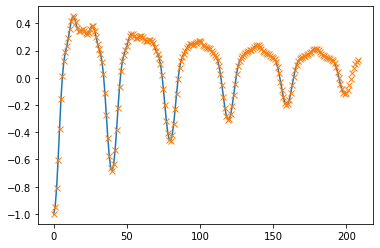

In [107]:
# Calculation sigma_z for true trajectories
sigma_z_train = prob.sigma(dens)
# Calculation sigma_z for DMD reconstructed trajectories
sigma_z_train_DMD = prob.sigma(tf.concat(
    [dens[0,:K-1], emb.predict(dens[0,:K], dens.shape[1])],
    axis=0)[tf.newaxis])
# Plotting
plt.plot(sigma_z_train[0,:,0])
plt.plot(sigma_z_train_DMD[0,:,0],'x')

Testing DMD performance: trajectory based on another initial data

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


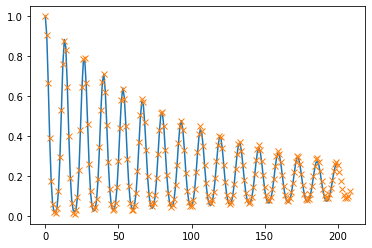

In [111]:
# intial state, second spin in state |1>, the rest in state |0>
psi_list = []
psi_list.append(basis(2,0)) # state |0>
psi_list.append(basis(2,1)) # state |1>
for n in range(N-2):
    psi_list.append(basis(2,0))
psi0 = tensor(psi_list)

# calculation trajectory with new initial data psi0
prob.set_problem(psi0=psi0) # update of problem initial state
dens_test = prob.solve() # integration

# Calculation sigma_z for true trajectories
sigma_z_test = prob.sigma(dens_test)
# Calculation sigma_z for DMD reconstructed trajectories
sigma_z_test_DMD = prob.sigma(tf.concat(
    [dens_test[0,:K-1], emb.predict(dens_test[0,:K], dens_test.shape[1])],
    axis=0)[tf.newaxis])
# Plotting
plt.plot(sigma_z_test[0,:,0])
plt.plot(sigma_z_test_DMD[0,:,0],'x')